# Hands-on 1: Hand-written image classification with the MNIST data set

This session introduces the use of neural network in a famous classification task: the image classification of hand-written digits from the MNIST data set.


The MNIST dataset is a widely used benchmark in the field of machine learning and computer vision. It consists of 70,000 grayscale images of handwritten digits (0-9), with each image being 28x28 pixels in size. The dataset is divided into 60,000 training images and 10,000 test images. MNIST serves as a standard dataset for evaluating classification algorithms and is commonly used for training and testing various machine learning models, particularly in the context of deep learning. Its simplicity and accessibility make it a popular starting point for those learning about image classification.

### What we will learn:

1. loading of data set
2. how to build simple neural network
3. training a model
4. evaluation of the model
5. how to make a prediction

In this tutorial we will use the same python environment as for the TA DNN reconstruction with the package pytorch.


** two more packages are reqired: jupyter, torchvision (for loading MNIST dataset)**

In [12]:
# load necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### 1. Loading the data set

Training and test set are loaded separateley. We need to evalute the model on the test set to ensure unbiased model evaluation and prevent overfitting, allowing for accurate assessments of the model's ability to generalize to unseen data.
Sometimes, the test set is used to cut when the networks does not train any more. In that case, a third set, the validation set, is required for inpendendent model evaluation.


Data loading is similar in TA DNN frame work, but specific for TA data format. The loader in this example is not direclty applicable to TA data (see hands-on session 2)

Note: normalization of the data is not necessary, but fastens the training process because the data is then within a defined range.

In [13]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [14]:
# check size of data set

print(len(train_dataset))
print(train_dataset[0])

60000
(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0

How the data looks like:

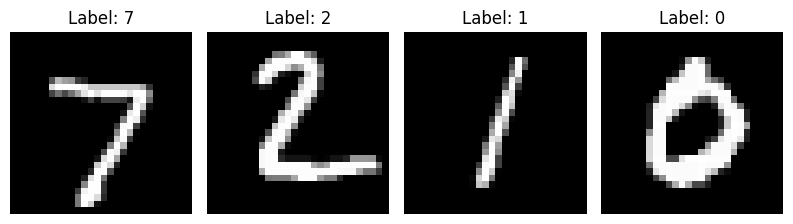

In [15]:
# Get a batch of images and labels
images, labels = next(iter(test_loader))

# Plot the first 4 images
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### 2. Build a simple model

The structure of adding layers / building blocks are always the same and are applicable to the TA DNN framework (see hands-on 3).

In `__init__`  the network is initalized. Layers and their sizes kann be added:

* `nn.Linear(input_features, output_features)` class in PyTorch is used to create a fully connected (dense) layer in a neural network.
   <br> The size of output features must match the number of class labels.

* here a linear transformation is perfomed: $y=xW^T +b$ where
  <br> $y$ is the output, <br> $x$ is the input, <br> $W$ is the weight matrix (learned parameters), <br> $b$ is the bias vector (also learned parameters).

* other options are: `nn.Conv1d`, `nn.Conv2d`, `nn.RNN`, `nn.MaxPool2d`, `nn.Sigmoid`, `nn.Dropout` etc.

* hidden layers use more dimension and the dimennsion of the final output is reduced in the last layer.


`forward()` defines what happends during the forward pass through the network. The input tensir is propagated through all layers.

* activation functions of each layer
* other option: `torch.sigmoid`, `torch.tanh` etc.

Note: Without the activation functions, any concatenation of linear layers is the same as just one layer.

In [16]:
class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)        # Hidden layer to hidden layer
        self.fc3 = nn.Linear(64, 10)         # Hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # Activation function 
        x = torch.relu(self.fc2(x))  # Activation function
        x = self.fc3(x)               # Output layer
        return x

model = SimpleDNN().to(device)
print(model)

SimpleDNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### 3. Train the model

Here we use Cross Entropy as loss function and the Adam optimizer. Optimizer, learning rate, loss function, and number of epochs can be adapted.

important settings:
<br> `optimizer.zero_grad()`: set gradients to zero because gradients are accummulated by default in pytorch
<br> `outputs = model(images)`: activations for each layer are calculated
<br> `loss.backward() `: computation of loss gradients. Weights are adjusted to minimize loss for next iteractions.


In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model = model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader: #load batches of training images
            images, labels = images.to(device), labels.to(device) # move images and labels to correct device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass of input data
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item() #accumulate loss of current epoch
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

train(model, train_loader, criterion, optimizer, epochs=5)


Epoch 1, Loss: 0.39192237805869024
Epoch 2, Loss: 0.18943387223506913
Epoch 3, Loss: 0.1380799707613075
Epoch 4, Loss: 0.11006375257450063
Epoch 5, Loss: 0.0928095087095269


### 4. Evaluate the  model

The model is evaluated on the test set. Note the following:

* `model.eval()`: evalulation metric should not be affected by stochastic elements. (Dropout layer is switched off - not used in this example)
* `torch.no_grad()`: disable gradient computation to save memory usage & speed up computation


In [18]:
def evaluate(model, test_loader):
    model = model.to(device)
    model.eval()
    correct = 0 #keep track of correct predictions
    total = 0 # total number
    with torch.no_grad():
        for images, labels in test_loader: # loop over all data in test set
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Forward pass of input data
            _, predicted = torch.max(outputs.data, 1) # find index of maximum value in outputs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

evaluate(model, test_loader)


Accuracy: 96.91%


### 5. Make a prediction


Here we make a prediction of an unknown image with a trained model.

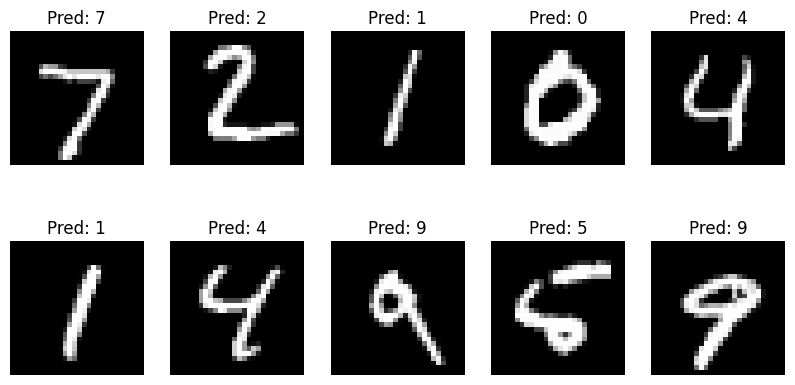

In [20]:
def plot_predictions(model, data_loader):
    model = model.to(device)
    model.eval()
    
    # Get a batch of images and labels
    images, labels = next(iter(data_loader))
    
    # Move images to the same device as the model
    images = images.to(device)  # Ensure images are on the same device (GPU/CPU)
    
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted class for each image
    _, predicted = torch.max(outputs.data, 1)  # Max value index -> class
    
    # Move images and labels back to CPU for plotting
    images = images.cpu()  # Move images back to CPU for matplotlib
    predicted = predicted.cpu()  # Also move predictions to CPU for displaying

    # Plot the first 10 images and their predictions
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Convert to NumPy after moving to CPU
        plt.title(f'Pred: {predicted[i].item()}')
        plt.axis('off')
    plt.show()

# Call the function to plot predictions
plot_predictions(model, test_loader)

After understanding building blocks of a neural network, it is now your turn:

## Exercise 1: Modify the Neural Network Architecture

Your task is to adapt and optimize a neural network for classifying handwritten digits using the MNIST dataset. You will be required to make modifications to the existing model architecture, training process, and evaluation techniques to improve performance.

a) Add an additional hidden layer to the existing model. Experiment with different numbers of neurons in the new layer (e.g., 128, 256) and see how it affects performance.

b)  Introduce an activation function other than ReLU for one of the hidden layers (e.g., Leaky ReLU, Tanh). Comapre it to the original ReLu in terms of training performance.


Note: Ensure you have the MNIST dataset loaded and a basic neural network model defined. You can start with a simple feedforward neural network architecture.


In [21]:
#solution a)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Input layer (784) -> First hidden layer (256) -> Second hidden layer (128) -> Output layer (10)
        self.fc1 = nn.Linear(784, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 128)   # Second hidden layer (new layer)
        self.fc3 = nn.Linear(128, 10)    # Output layer
        self.relu = nn.ReLU()             # Activation function

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.relu(self.fc1(x))  # First layer
        x = self.relu(self.fc2(x))  # Second layer
        x = self.fc3(x)              # Output layer
        return x


In [22]:
model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=5):
    model = model.to(device)
    model.train()
    loss_values = []  # List to store loss values
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
       
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)  # Append average loss for the epoch
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

# Train the model
train(model, train_loader, criterion, optimizer, epochs=5)


Epoch 1, Loss: 0.3351218477884399
Epoch 2, Loss: 0.15060803224382274
Epoch 3, Loss: 0.11425331252505944
Epoch 4, Loss: 0.09221587249828475
Epoch 5, Loss: 0.07701813996926363


In [23]:
# solution b)

class SimpleNNWithTanh(nn.Module):
    def __init__(self):
        super(SimpleNNWithTanh, self).__init__()
        # Input layer (784) -> First hidden layer (256) -> Second hidden layer (128) -> Output layer (10)
        self.fc1 = nn.Linear(784, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 128)   # Second hidden layer (using Tanh)
        self.fc3 = nn.Linear(128, 10)    # Output layer
        self.relu = nn.ReLU()             # Activation function for the first layer
        self.tanh = nn.Tanh()             # Tanh activation function for the second layer

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.relu(self.fc1(x))  # First layer with ReLU
        x = self.tanh(self.fc2(x))   # Second layer with Tanh
        x = self.fc3(x)               # Output layer
        return x
    
model_tanh = SimpleNNWithTanh().to(device)


criterion = nn.CrossEntropyLoss()
optimizer_tanh = optim.Adam(model_tanh.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=5):
    model = model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

# Train the Tanh model
train(model_tanh, train_loader, criterion, optimizer_tanh, epochs=5)




Epoch 1, Loss: 0.314688803779005
Epoch 2, Loss: 0.13804988602577434
Epoch 3, Loss: 0.10411315963172646
Epoch 4, Loss: 0.08222560708357422
Epoch 5, Loss: 0.0713660218916746


### Exercise 2: Evaluate the model performance

After training, evaluate your model on the test dataset and report the accuracy.

Generate a confusion matrix to visualize the model's performance on each digit class.
Plot some example predictions alongside their true labels and analyze any misclassifications.

(Subtask: Discuss possible reasons for misclassifications and suggest potential improvements. )

In [24]:
# Define function to evaluate and report accuracy
def evaluate_and_report(model, test_loader):
    model = model.to(device)
    model.eval()
    num_classes = 10  # MNIST has 10 digit classes (0-9)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Initialize empty confusion matrix
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    # Normalize the confusion matrix along rows (true labels)
    cm_normalized = confusion_matrix.astype(float) / confusion_matrix.sum(axis=1, keepdims=True)

    # Handle NaN values which can occur if a row sum is zero (no true labels for a class)
    cm_normalized = np.nan_to_num(cm_normalized)

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    # Add labels to the plot
    threshold = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f'{cm_normalized[i, j]:.2f}', 
                 horizontalalignment="center", 
                 color="white" if cm_normalized[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    return accuracy, confusion_matrix

In [25]:
def plot_example_predictions(model, data_loader, num_examples=10):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(data_loader))
    
    # Move images and labels to the same device as the model
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass through the model
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)  # Get predicted classes

    # Move images and labels back to CPU for plotting
    images = images.cpu()  # Move images to CPU
    labels = labels.cpu()  # Move labels to CPU
    predicted = predicted.cpu()  # Move predictions to CPU

    # Plot the first 'num_examples' images with their predicted and true labels
    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Convert to NumPy after moving to CPU
        plt.title(f'True: {labels[i].item()}\nPred: {predicted[i].item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Identify and print misclassified examples
    misclassified = (predicted != labels)
    if misclassified.sum() > 0:
        print(f'Misclassified examples: {misclassified.sum()}/{num_examples}')
        
        # Get misclassified images and their labels
        misclass_images = images[misclassified]
        misclass_labels = labels[misclassified]
        misclass_preds = predicted[misclassified]
        
        # Move misclassified examples back to CPU for plotting
        misclass_images = misclass_images.cpu()
        misclass_labels = misclass_labels.cpu()
        misclass_preds = misclass_preds.cpu()
        
        # Plot misclassified examples
        plt.figure(figsize=(12, 6))
        for i in range(min(10, misclassified.sum())):
            plt.subplot(2, 5, i + 1)
            plt.imshow(misclass_images[i].numpy().squeeze(), cmap='gray')  # Convert to NumPy after moving to CPU
            plt.title(f'True: {misclass_labels[i].item()}\nPred: {misclass_preds[i].item()}')
            plt.axis('off')
        plt.suptitle('Misclassified Examples')
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified examples found.")

Accuracy: 97.30%


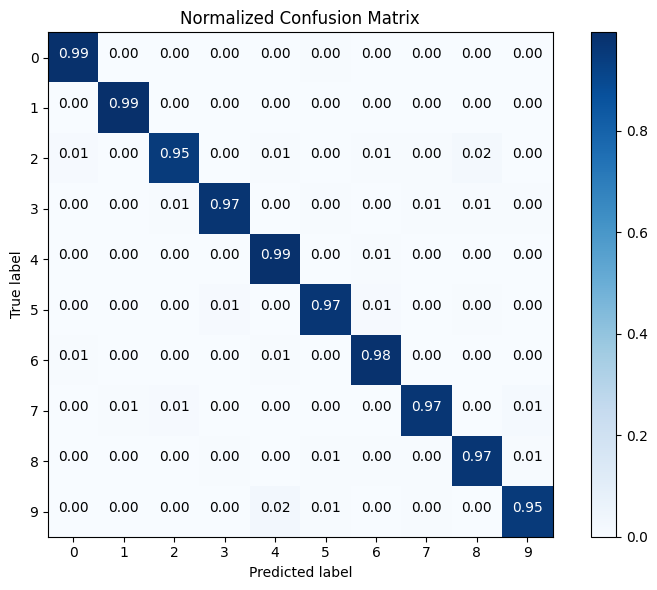

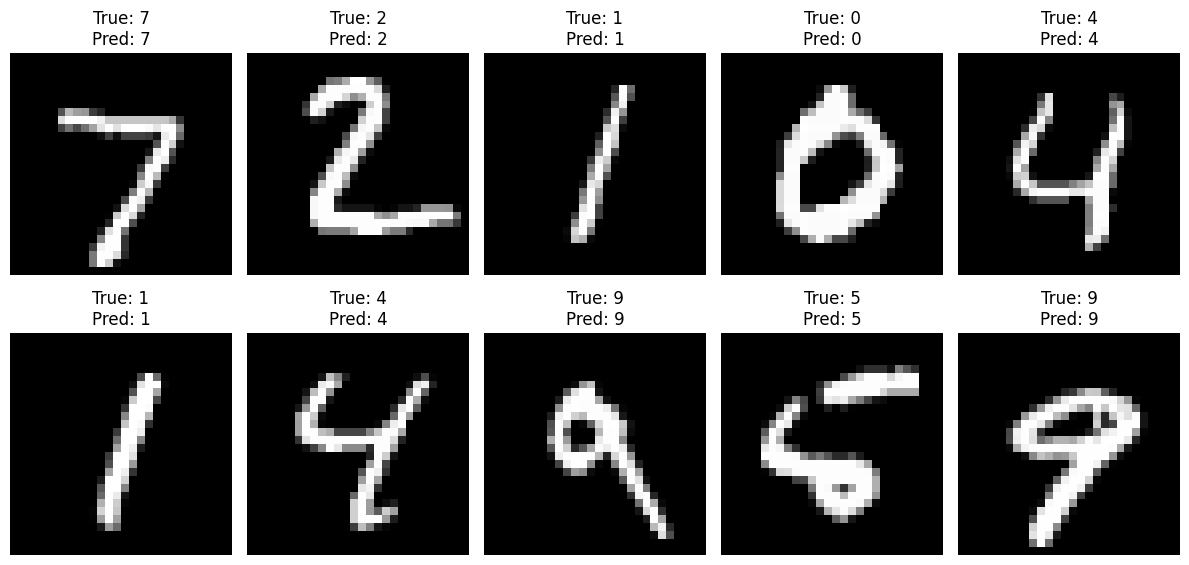

No misclassified examples found.


In [26]:
accuracy, cm = evaluate_and_report(model, test_loader)
plot_example_predictions(model, test_loader)

#### Potential reasons for misclassification:

* Ambiguity in Handwritten Digits:
<br> Handwritten digits can have significant variations depending on the individual style, which can cause ambiguity.
* Insufficient Model Capacity:
<br> The current model (SimpleDNN) is a relatively small fully-connected network with only two hidden layers. This architecture may not have enough capacity to learn complex patterns in the dataset.
More sophisticated architectures like Convolutional Neural Networks (CNNs) are better suited for image data as they can capture spatial hierarchies in the image pixels (e.g., edges, textures, and shapes) more effectively.
* Overfitting to the Training Data:
<br> If the model is overfitting, it means that it performs well on the training data but struggles to generalize to unseen test data. Overfitting can occur due to:
Lack of regularization techniques (e.g., dropout or batch normalization).
Using a fixed and small training dataset without any augmentation, making it harder for the model to generalize to new inputs.
* Underfitting Due to Limited Training:
<br> If the model is not trained long enough or the learning rate is too high, it may not converge to an optimal solution, leading to underfitting.
This causes the model to have high error rates on both the training and test sets as it hasn't fully learned the underlying patterns in the data.
* Noise in the Dataset:
<br> Although the MNIST dataset is generally clean, there can still be mislabeled or noisy samples.
* Unbalanced Data Representation:
<br> While MNIST is fairly balanced, the presence of a few minority classes in other datasets can lead to a bias where the model predicts the majority class more often, resulting in misclassifications.

### Exercise 3: Optimize the Training Process

Experiment with different optimizers (e.g., Adam, SGD, RMSprop).

Compare the training time and final accuracy for each optimizer and provide a brief analysis of your findings.



Training with Adam Optimizer
Epoch 1, Loss: 0.38823285054709356
Epoch 2, Loss: 0.18465045280953143
Epoch 3, Loss: 0.13723565329477858
Epoch 4, Loss: 0.10979938025582335
Epoch 5, Loss: 0.09302521458239174
Accuracy: 96.69%


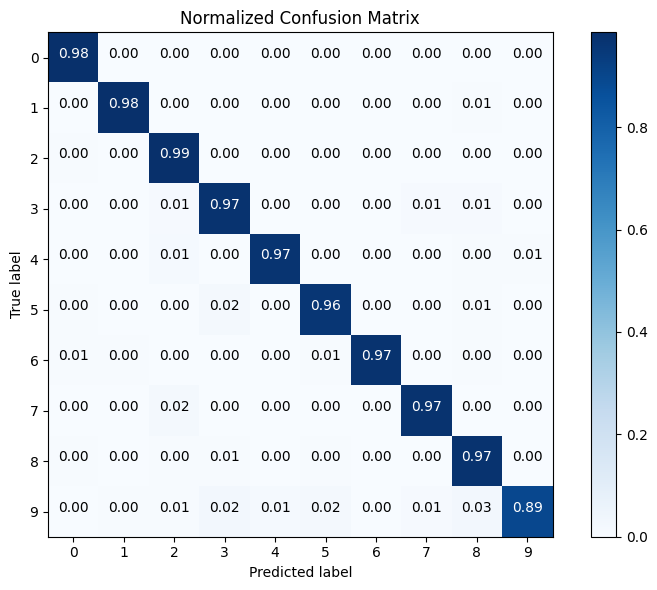


Training with SGD Optimizer
Epoch 1, Loss: 2.2246806669845256
Epoch 2, Loss: 1.9417616838076983
Epoch 3, Loss: 1.4547899469637922
Epoch 4, Loss: 1.0298628937333887
Epoch 5, Loss: 0.7840386645308436
Accuracy: 83.33%


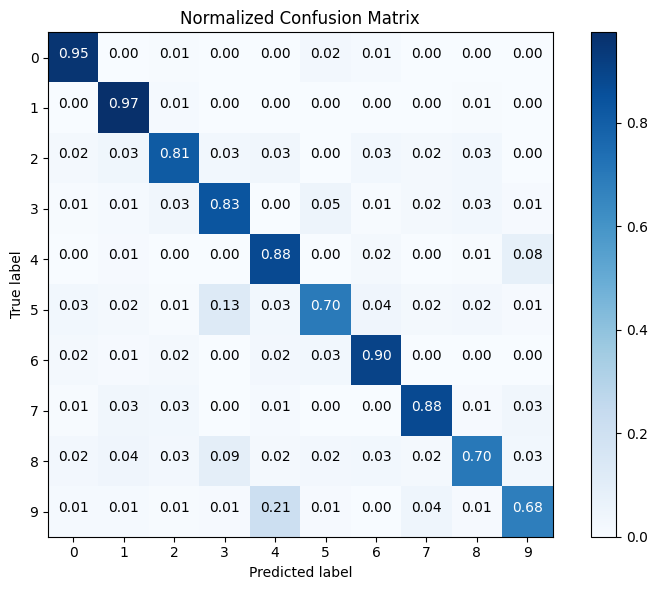


Training with RMSprop Optimizer
Epoch 1, Loss: 0.373831130429181
Epoch 2, Loss: 0.17939731737038792
Epoch 3, Loss: 0.1344056027605812
Epoch 4, Loss: 0.11082942358085088
Epoch 5, Loss: 0.09497227111378553
Accuracy: 95.79%


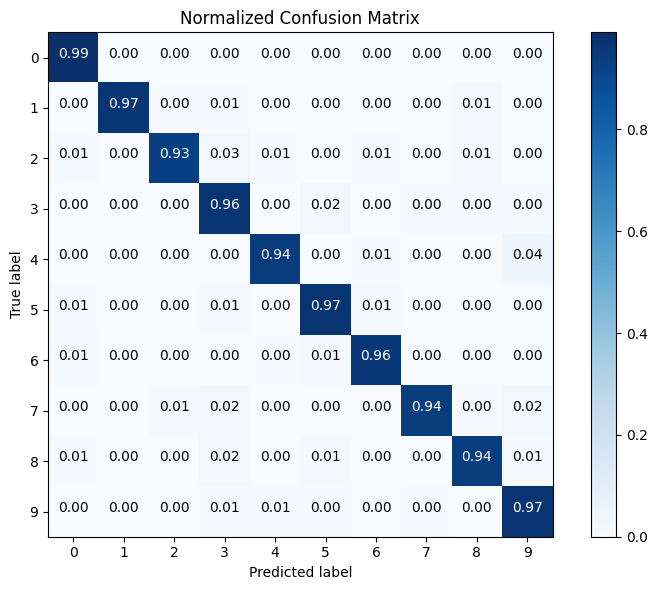


--- Optimizer Comparison ---
Adam     - Training Time: 21.45 seconds, Test Accuracy: 96.69%
SGD      - Training Time: 17.04 seconds, Test Accuracy: 83.33%
RMSprop  - Training Time: 19.38 seconds, Test Accuracy: 95.79%


In [27]:
import time

# Define a function to train the model with a specified optimizer and return training time and final accuracy
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5):
    model.to(device)
    model.train()
    for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
    start_time = time.time()  # Start the timer for training time measurement

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

    training_time = time.time() - start_time  # Calculate the elapsed time

    # Evaluate the model on the test set
    accuracy, _ = evaluate_and_report(model, test_loader)
    
    return training_time, accuracy

# Reset the model before each training session
def reset_model():
    return SimpleDNN().to(device)

# Define loss function and learning rate
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

# Train and evaluate using Adam optimizer
print("\nTraining with Adam Optimizer")
model = reset_model()
optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate)
adam_time, adam_accuracy = train_and_evaluate(model, train_loader, test_loader, optimizer_adam, criterion, epochs=5)

# Train and evaluate using SGD optimizer
print("\nTraining with SGD Optimizer")
model = reset_model()
optimizer_sgd = optim.SGD(model.parameters(), lr=learning_rate)
sgd_time, sgd_accuracy = train_and_evaluate(model, train_loader, test_loader, optimizer_sgd, criterion, epochs=5)

# Train and evaluate using RMSprop optimizer
print("\nTraining with RMSprop Optimizer")
model = reset_model()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=learning_rate)
rmsprop_time, rmsprop_accuracy = train_and_evaluate(model, train_loader, test_loader, optimizer_rmsprop, criterion, epochs=5)

# Summarize and compare results
print("\n--- Optimizer Comparison ---")
print(f"Adam     - Training Time: {adam_time:.2f} seconds, Test Accuracy: {adam_accuracy:.2f}%")
print(f"SGD      - Training Time: {sgd_time:.2f} seconds, Test Accuracy: {sgd_accuracy:.2f}%")
print(f"RMSprop  - Training Time: {rmsprop_time:.2f} seconds, Test Accuracy: {rmsprop_accuracy:.2f}%")


* Adam:

Training Time: Usually slower than SGD but faster than RMSprop due to its adaptive learning rate properties.
Accuracy: Often achieves the best or near-best accuracy in a limited number of epochs due to its efficient parameter updates.

* SGD:

Training Time: Generally the fastest optimizer but can struggle with convergence or achieving high accuracy without additional techniques like momentum or learning rate scheduling.
Accuracy: May lag behind other optimizers in terms of final accuracy since it uses a constant learning rate.

* RMSprop:

Training Time: Often in between Adam and SGD due to its adaptive learning rate properties similar to Adam.
Accuracy: Typically performs better than SGD but may not always surpass Adam, especially for simple networks like the one used here.